In [172]:
## Mpho Manamela 
## DS4ASTRO Simulating and Fitting to Orbits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy.optimize import curve_fit
from scipy.stats import norm

## Function to calculating the semi-major axis (sma)
def sma(T_days, M_kg):
    T_sec = T_days * u.day
    a = ((const.G * M_kg * u.kg * T_sec**2) / (4 * np.pi**2))**(1/3)
    return a.to(u.au).value
    


In [144]:
## Simulating 5 fake planets orbital
P_orbitals = np.random.randint(100,100000,5) ## 5 random planet orbitals in days
#print(P_orbitals)


[11613 59378 66561 15089 99130]


In [146]:
## Calculating the semi major axis for each fake planet
M_kg = 1.98816e30 ## Since all planets are orbiting the Sun and assuming that the Sun is more massive than all of them 
a_planets = []
for planet in P_orbitals:
    a_p = sma(planet,M_kg)
    a_planets.append(a_p)

a_planets = np.array(a_planets)
#print(a_planets)


[10.03565693 29.7851574  32.1412489  11.94968604 41.91662044]


In [147]:
## Generating noise for each measurement
a_noise = []
a_uncertainties = []
for a_p in a_planets:
    sigma = a_p/10
    gaus_noise = np.random.normal(loc=0, scale = sigma)
    a_noise.append(a_p+gaus_noise)
    a_uncertainties.append(sigma)

a_uncertainties = np.array(a_uncertainties)
a_noise = np.array(a_noise)
#print(a_noise)
#print(a_uncertainties)

[10.08302037 33.61898786 36.48475227 12.76761927 43.14620286]
[1.00356569 2.97851574 3.21412489 1.1949686  4.19166204]


Best-fit mass: 2.458e+30 kg
1σ uncertainty on mass: 1.789e+29 kg
True mass: 1.988e+30 kg
SNR: 1.374e+01


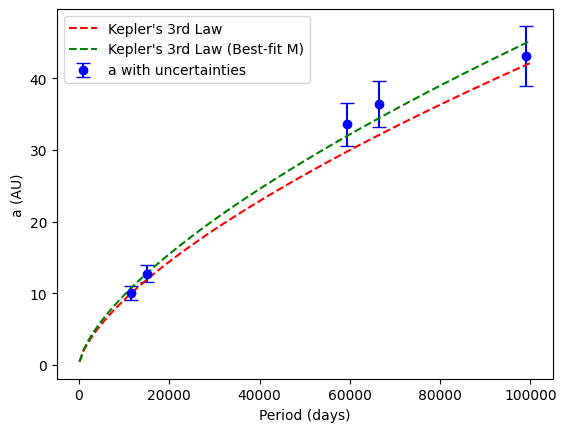

In [149]:
## Plotting

## Predictive curve from Kepler's law
P_range = np.linspace(100, 100000, 100)  ## Periods from 100 to 100000 days

def kepler3l(period_days, M_kg):
    period = period_days * u.day
    a_cubed = (const.G * M_kg * u.kg * period**2) / (4 * np.pi**2)
    return (a_cubed ** (1/3)).to(u.au).value

a_theoretical = [kepler3l(p, M_kg) for p in P_range] ## a from predictive curve 

## Best fit curve using curve_fit
popt, pcov = curve_fit(kepler3l, P_orbitals, a_noise, sigma=a_uncertainties, p0=[M_kg])
best_fit_mass = popt[0]
mass_uncertainty = np.sqrt(pcov[0,0])  # 1σ uncertainty on mass

print(f"Best-fit mass: {best_fit_mass:.3e} kg")
print(f"1σ uncertainty on mass: {mass_uncertainty:.3e} kg")
print(f"True mass: {M_kg:.3e} kg")

## Best-fit curve
a_best_fit = [kepler3l(p, best_fit_mass) for p in P_range]

## Calculating the signal-to-noise ratio of best-fit mass
snr_mass = best_fit_mass / mass_uncertainty
print(f"SNR: {snr_mass:.3e}")

plt.errorbar(P_orbitals, a_noise, a_uncertainties, fmt='o', capsize=5, markersize=6, color='b', label = "a with uncertainties")
plt.plot(P_range, a_theoretical,'r--', label="Kepler's 3rd Law ")
plt.plot(P_range, a_best_fit, 'g--', label="Kepler's 3rd Law (Best-fit M)")
plt.xlabel("Period (days)")
plt.ylabel("a (AU)")
plt.legend()
plt.savefig("step1-8")
plt.show()


 SNR = 1 


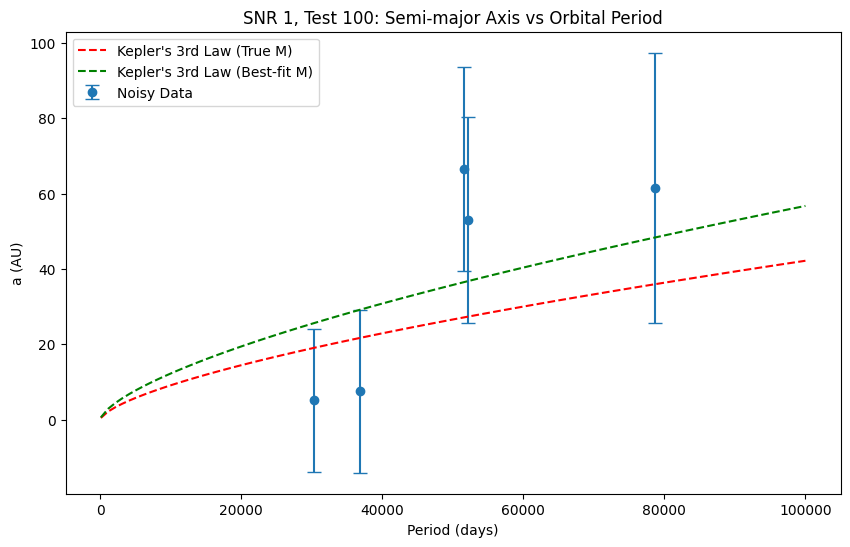

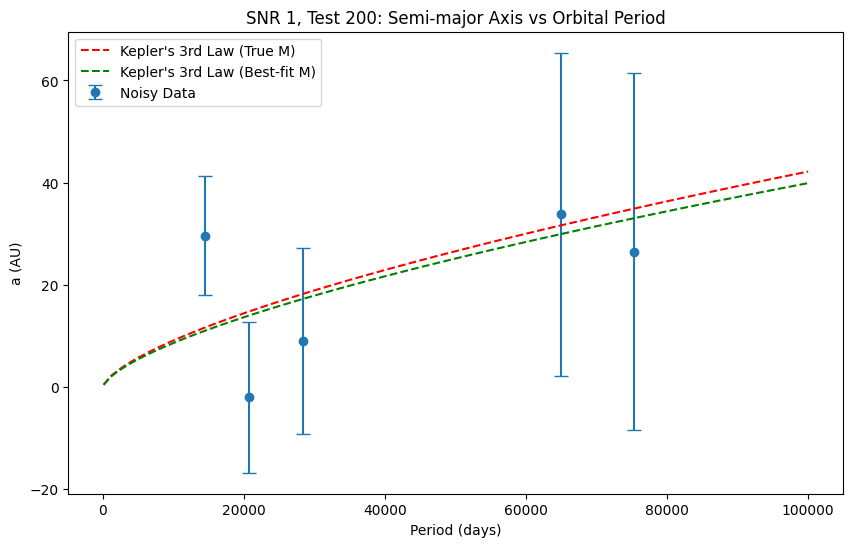

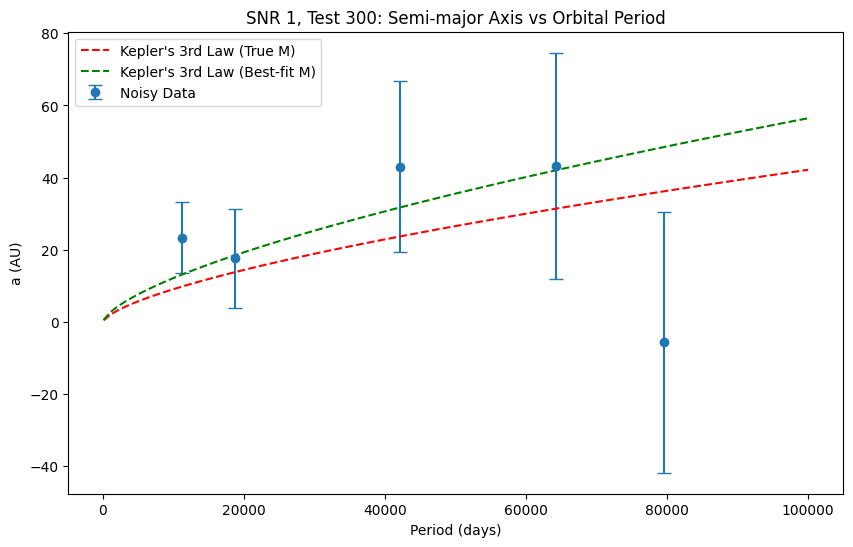

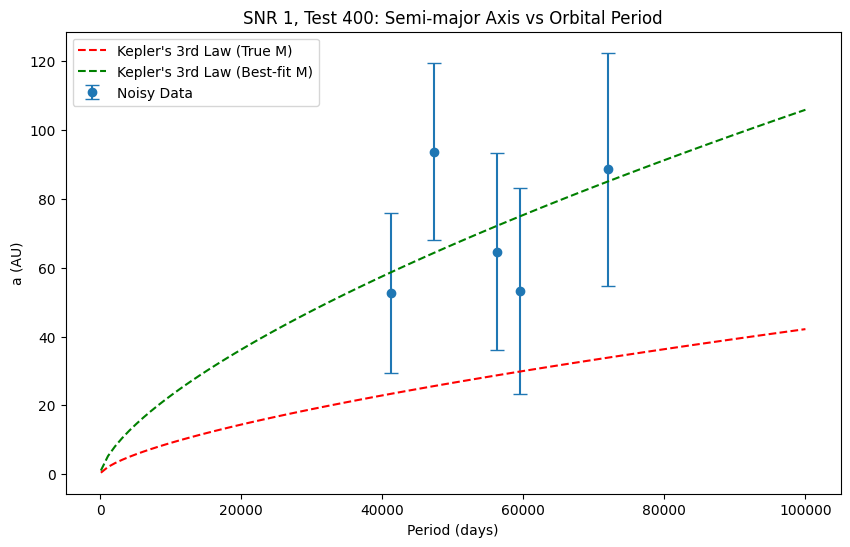

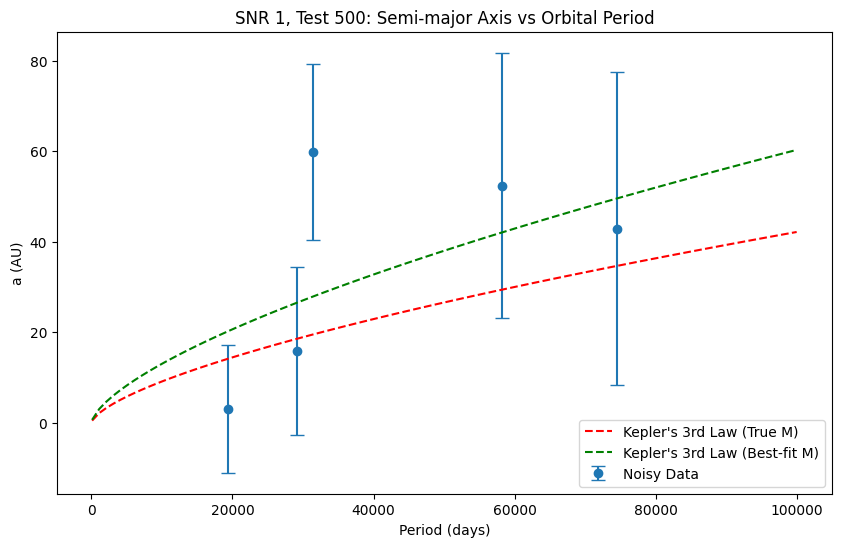

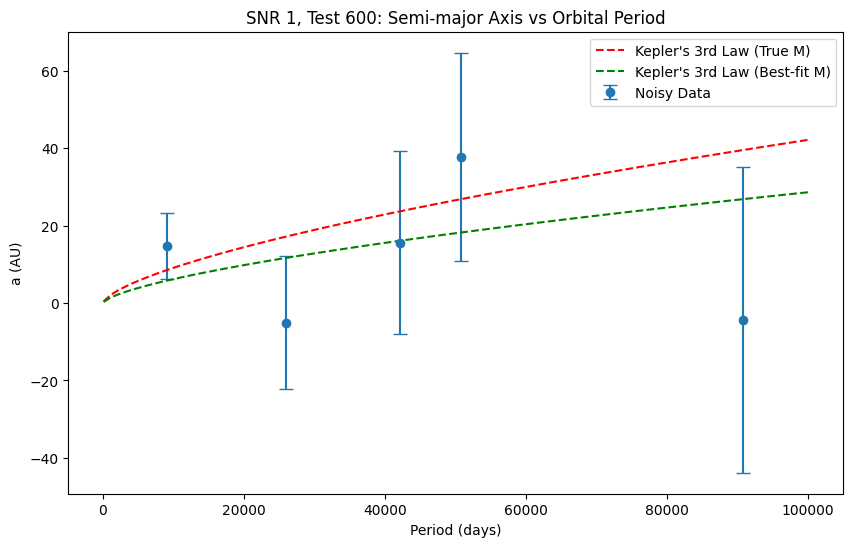

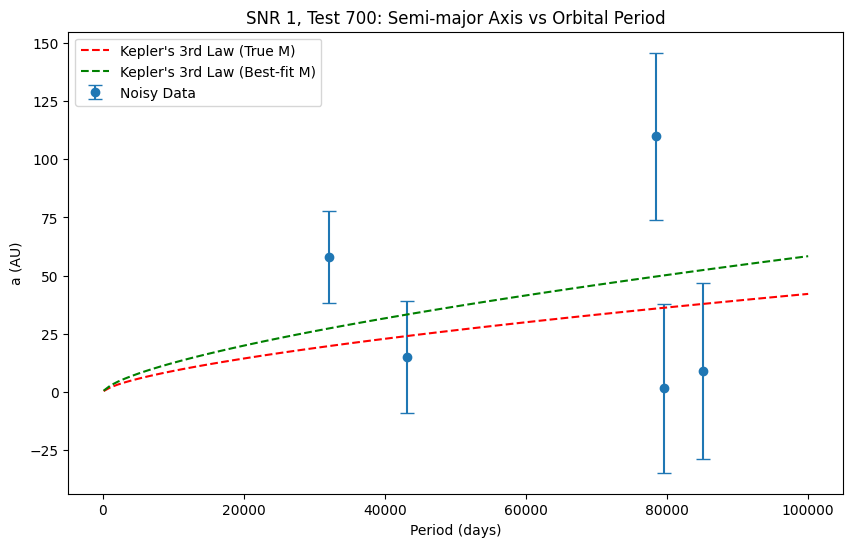

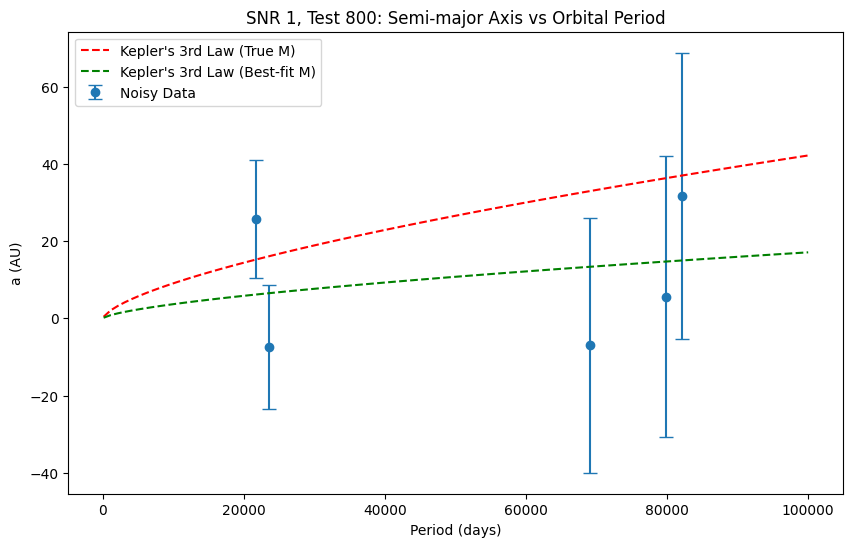

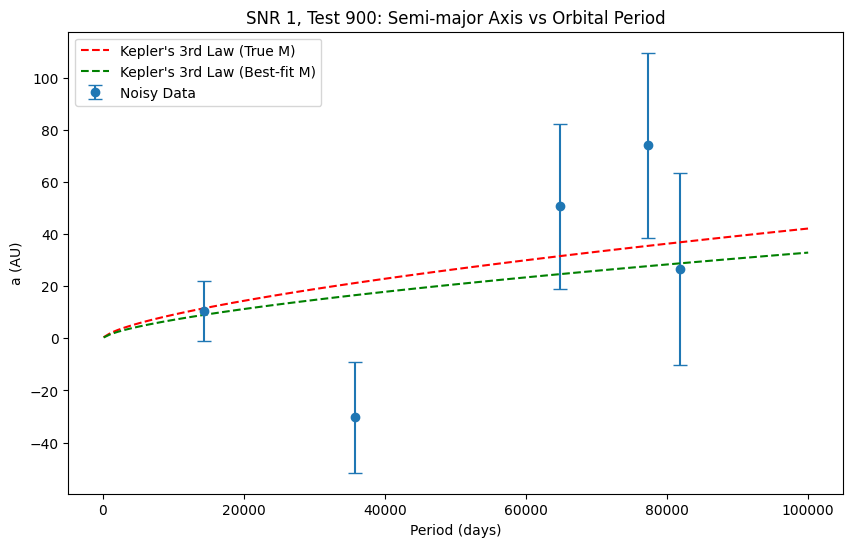

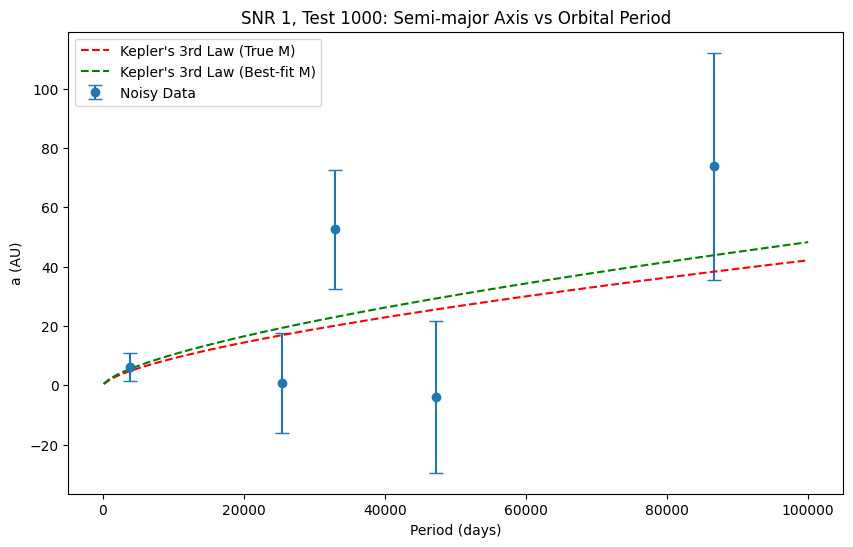

Fraction agreeing within 1sigma: 0.590
Median best-fit mass: 1.826e+30 kg
Uncertainty on median: 1.446e+29 kg
Deviation of median: 1.12sigma
Agrees within uncertainty: False


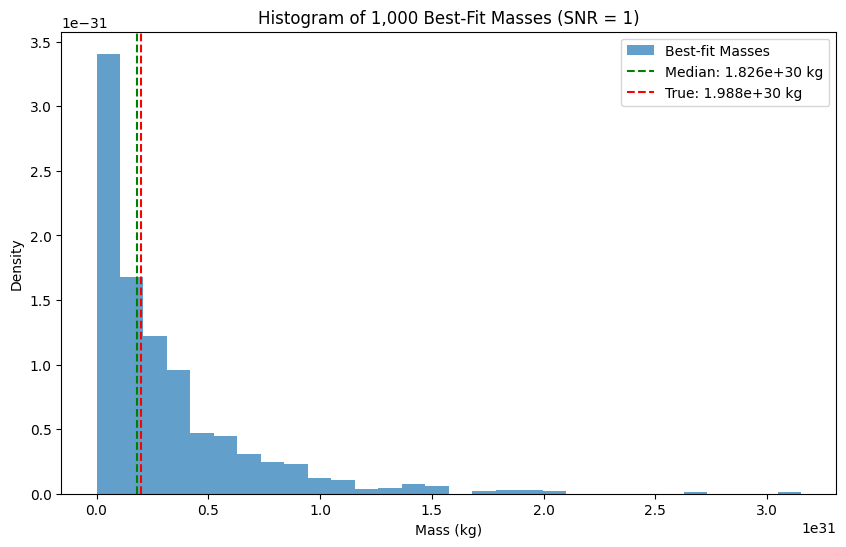


 SNR = 3 


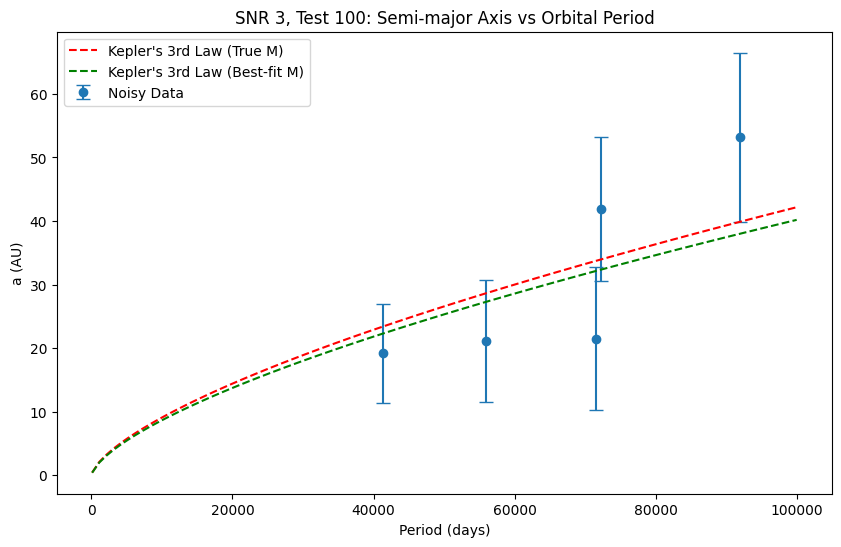

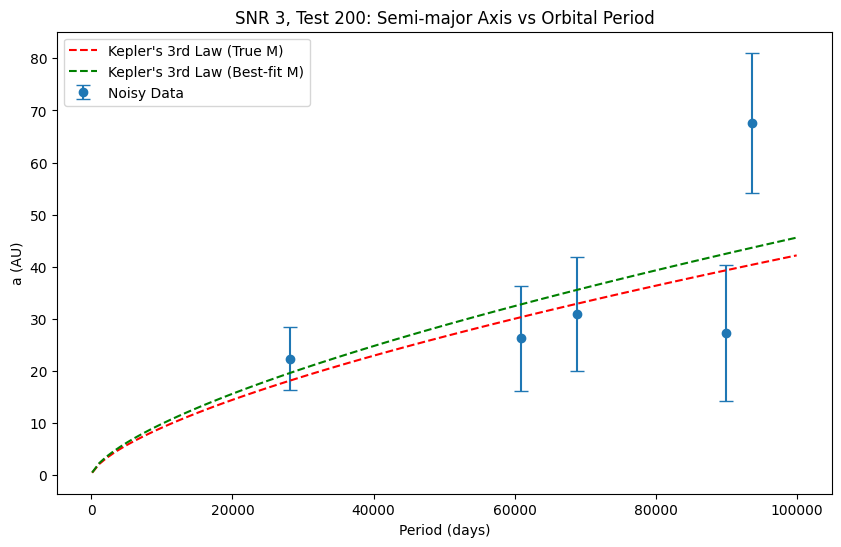

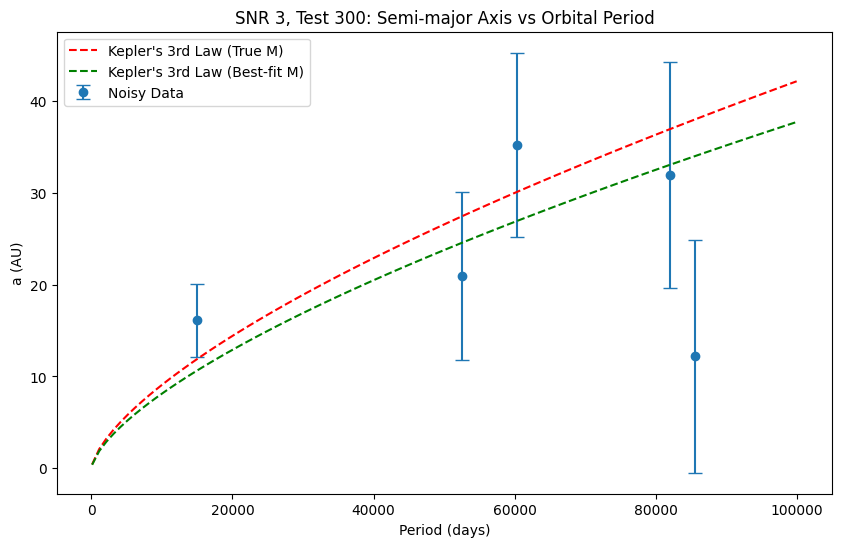

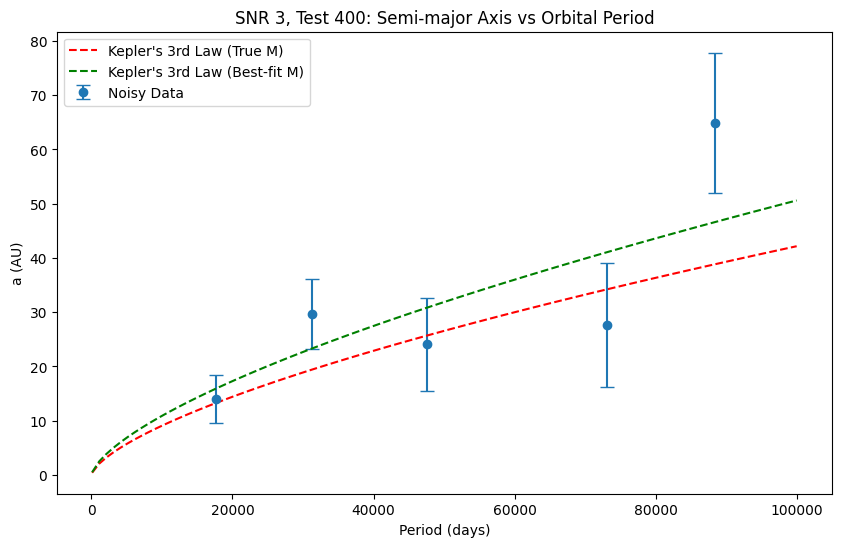

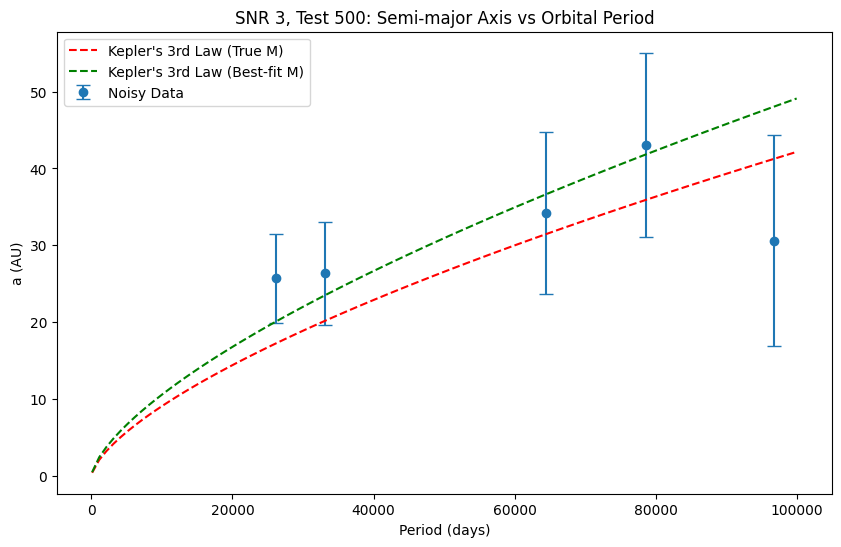

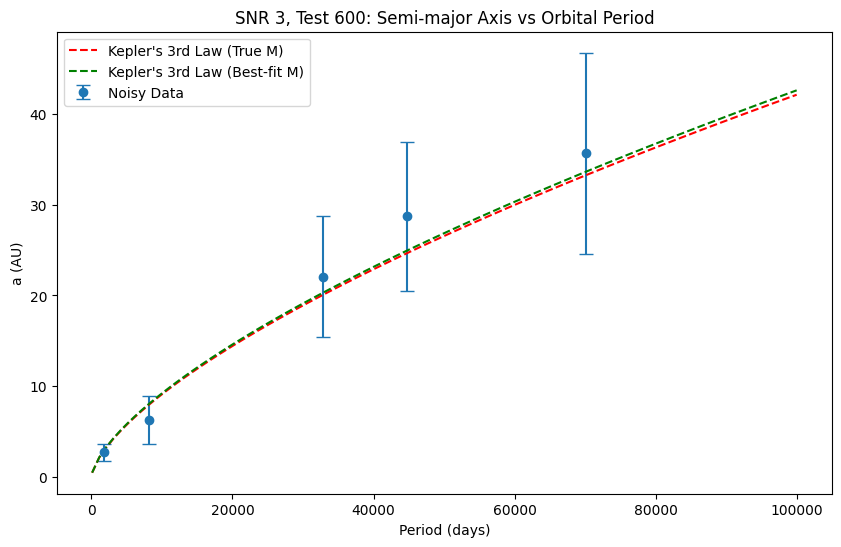

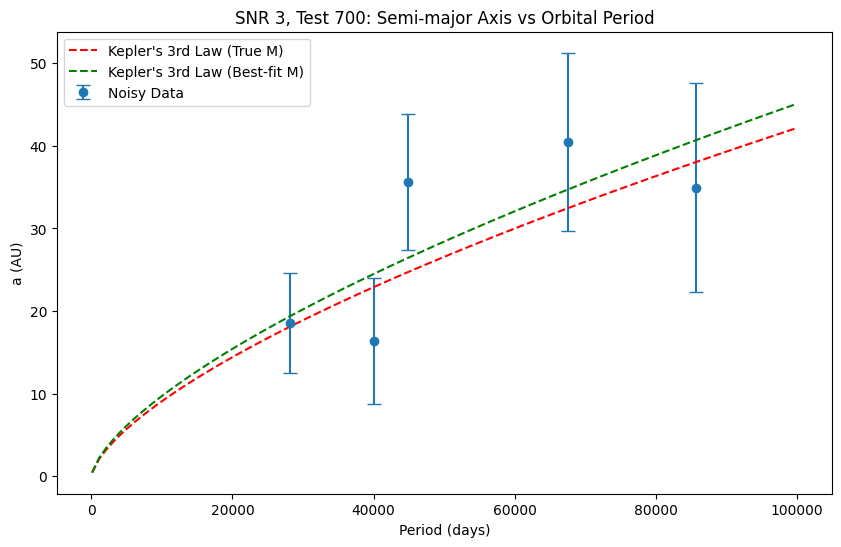

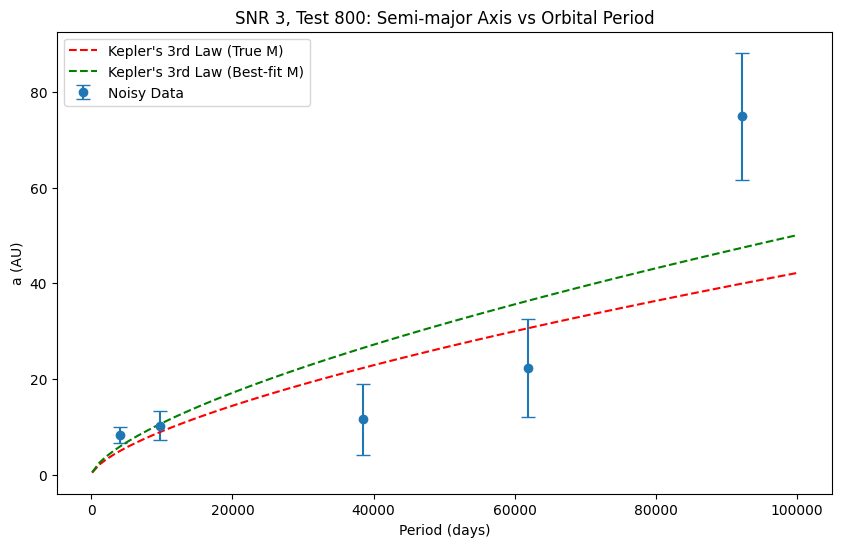

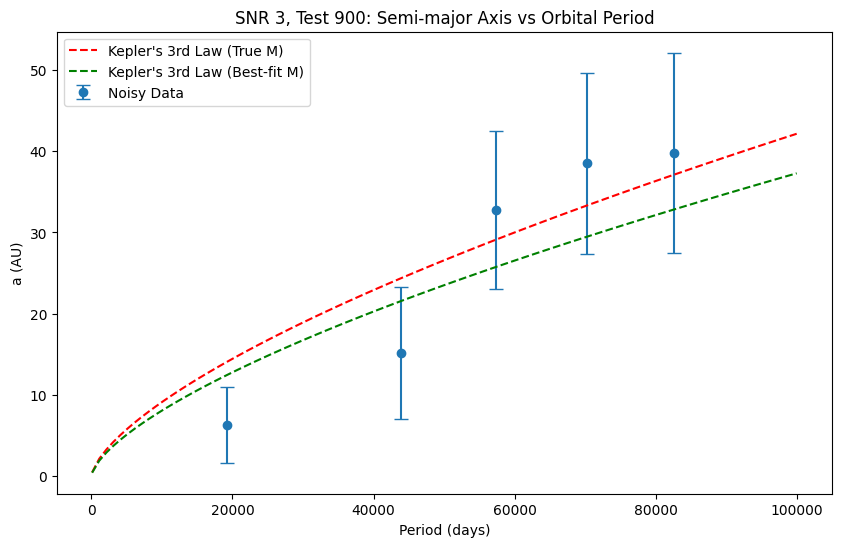

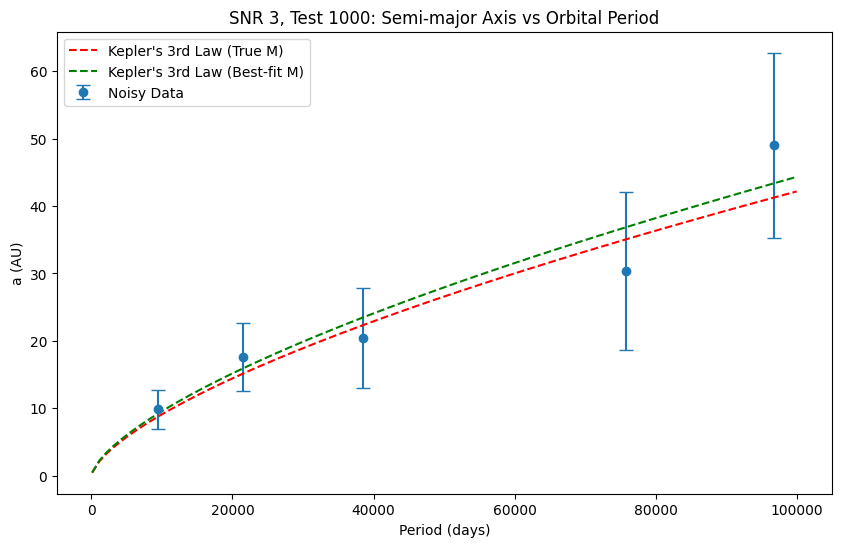

Fraction agreeing within 1sigma: 0.647
Median best-fit mass: 2.030e+30 kg
Uncertainty on median: 3.518e+28 kg
Deviation of median: 1.20sigma
Agrees within uncertainty: False


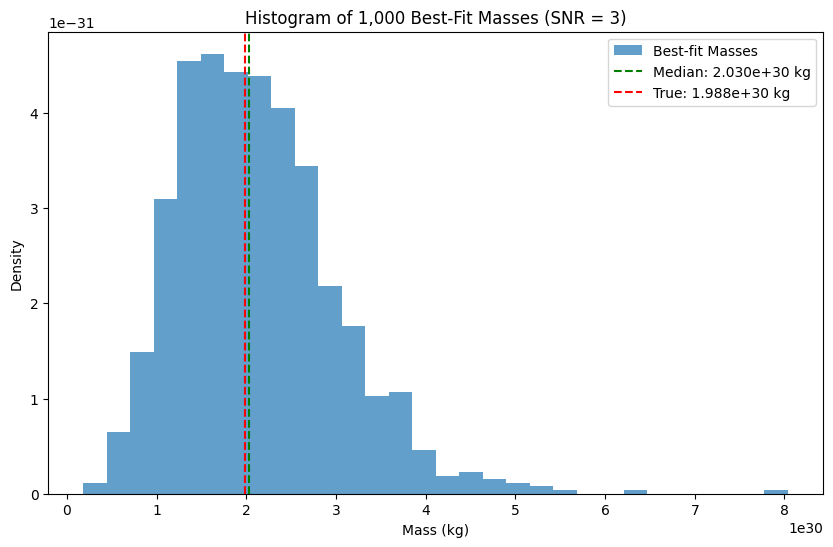


 SNR = 5 


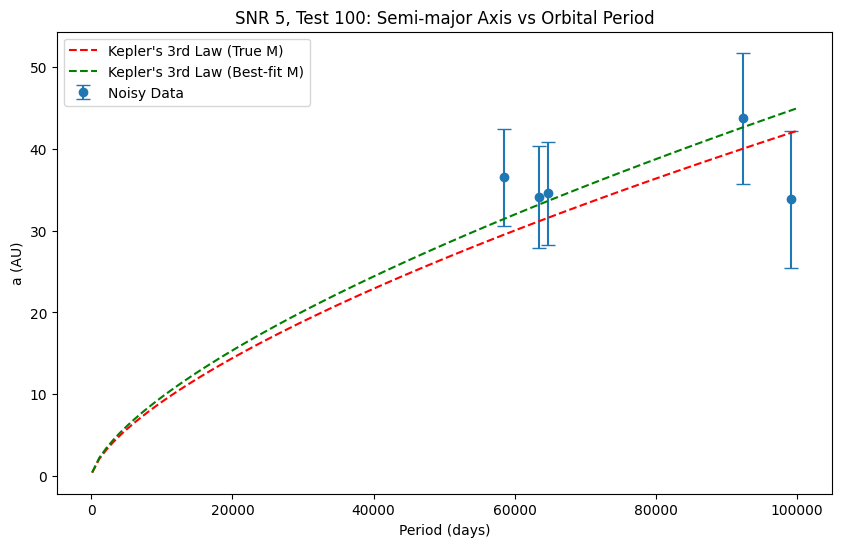

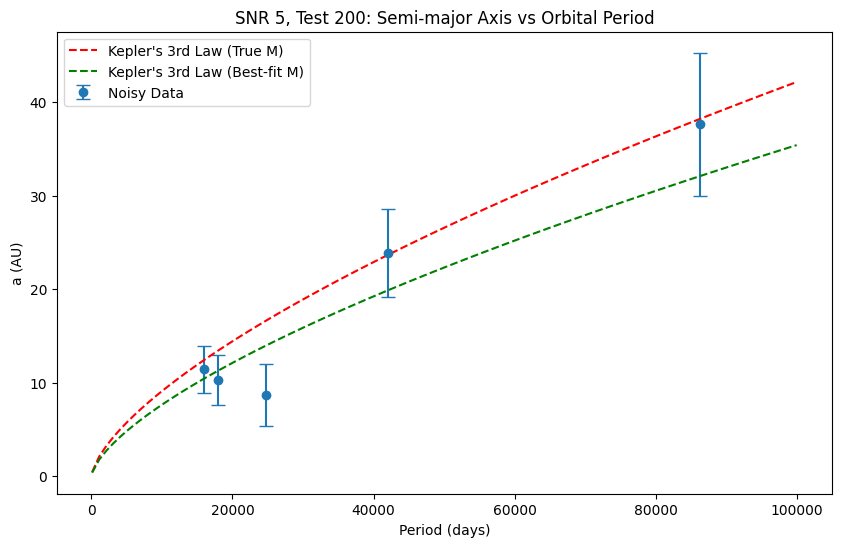

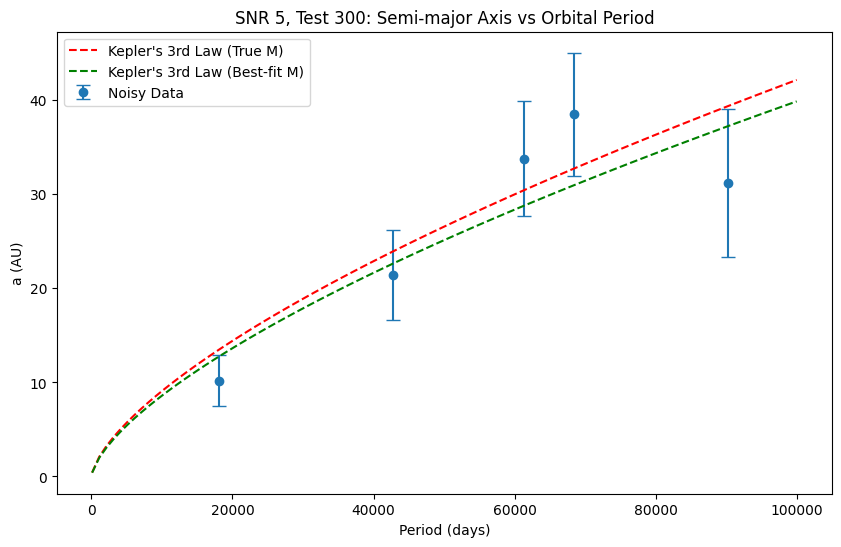

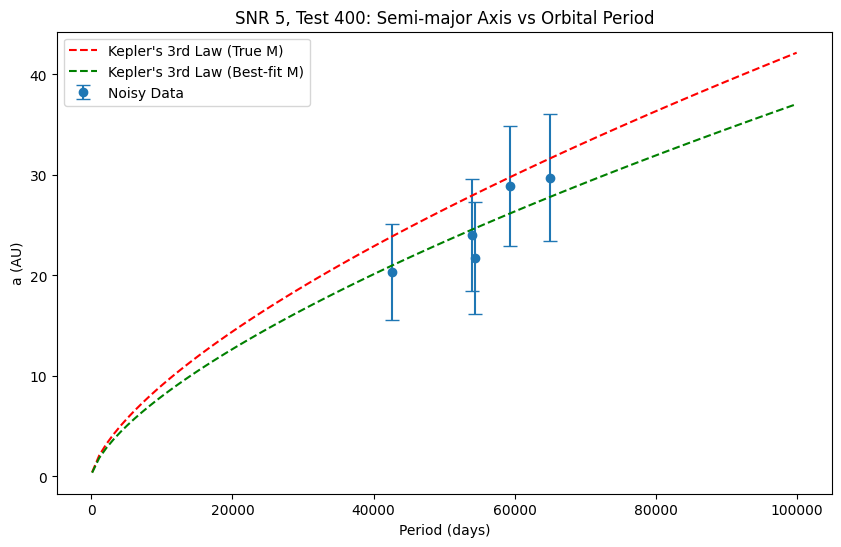

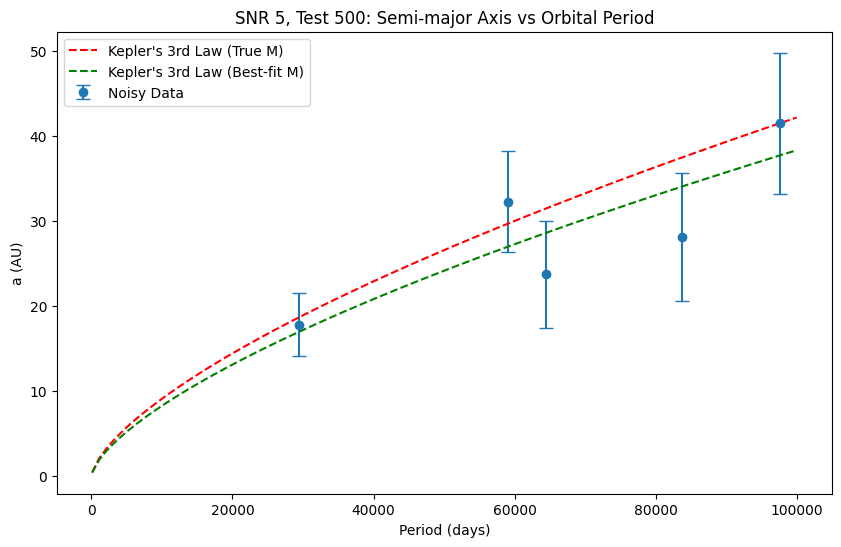

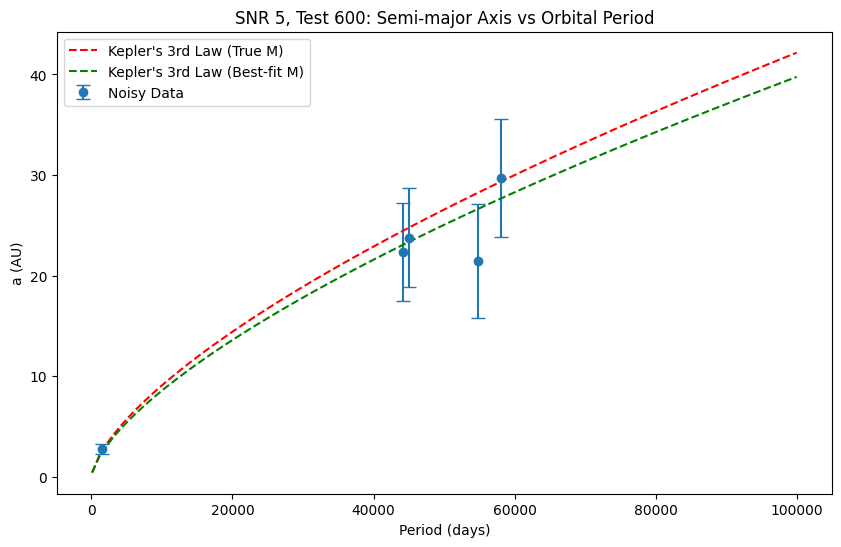

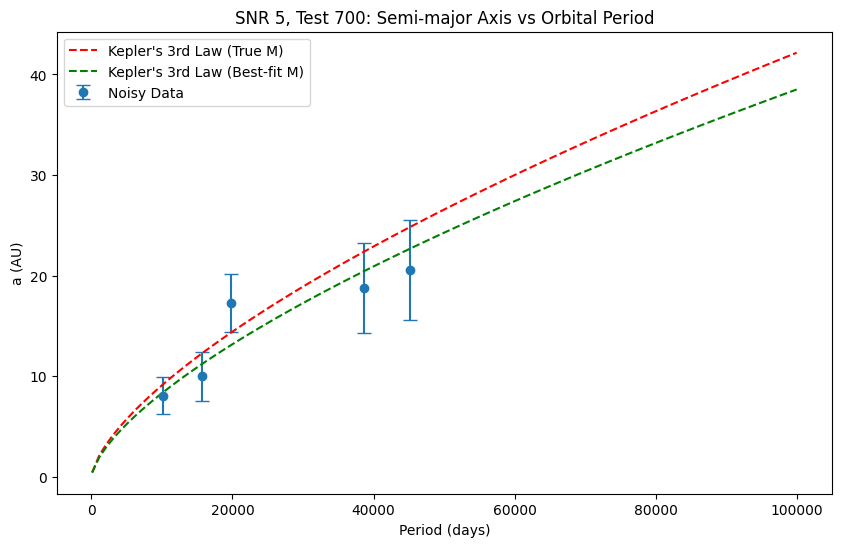

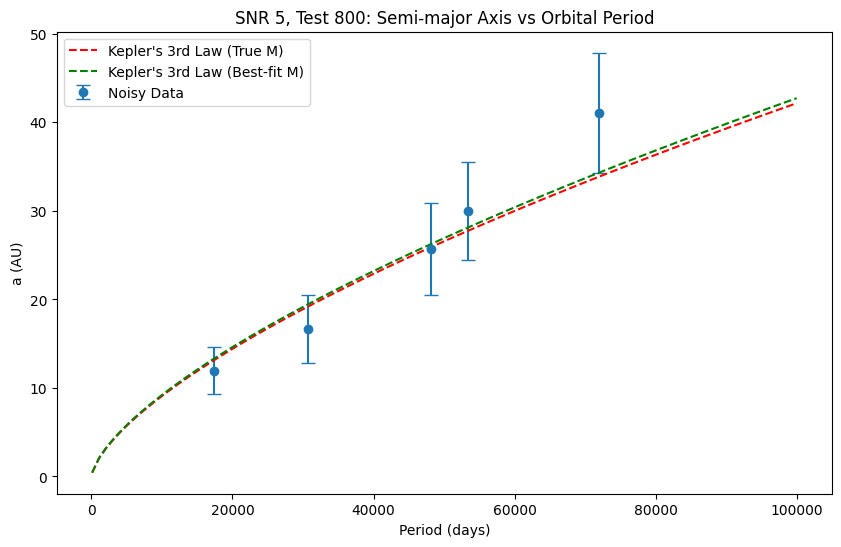

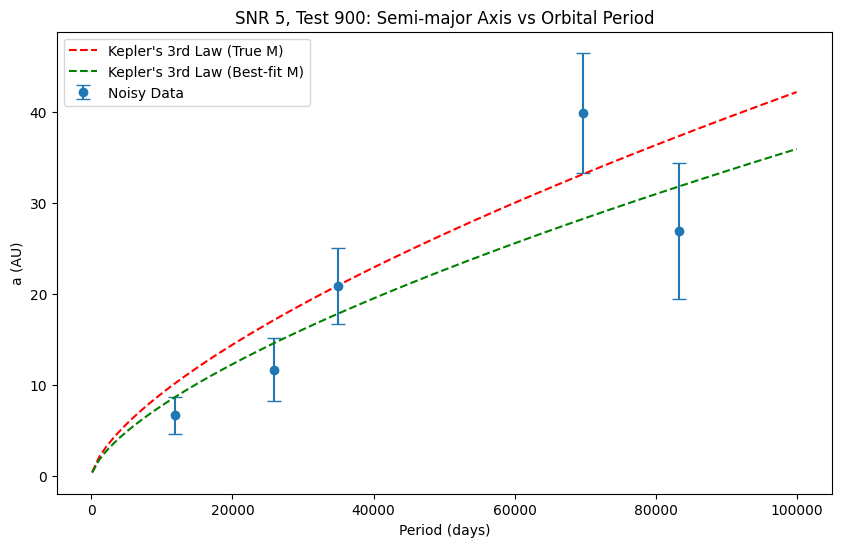

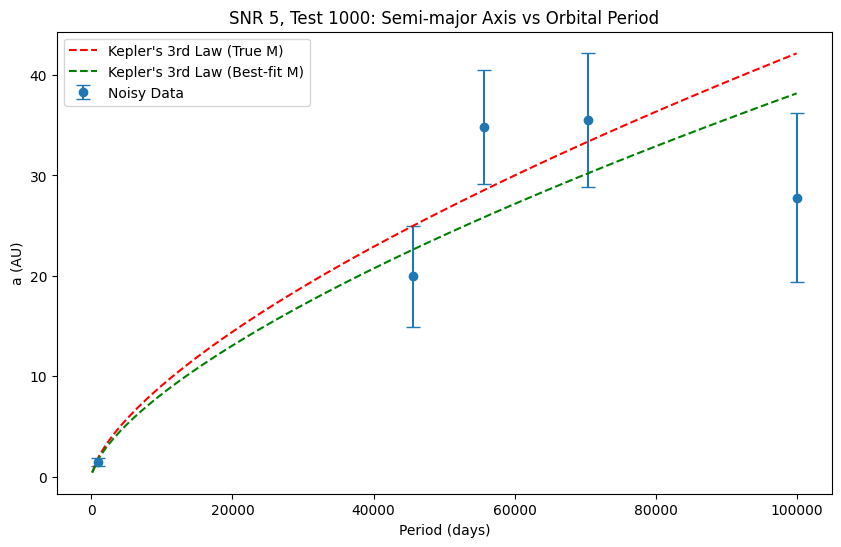

Fraction agreeing within 1sigma: 0.603
Median best-fit mass: 1.989e+30 kg
Uncertainty on median: 2.181e+28 kg
Deviation of median: 0.03sigma
Agrees within uncertainty: True


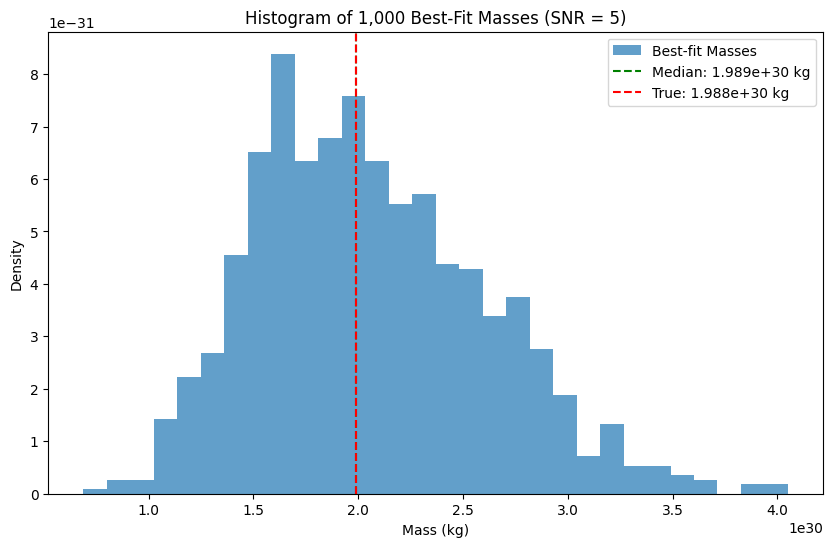


 SNR = 100 


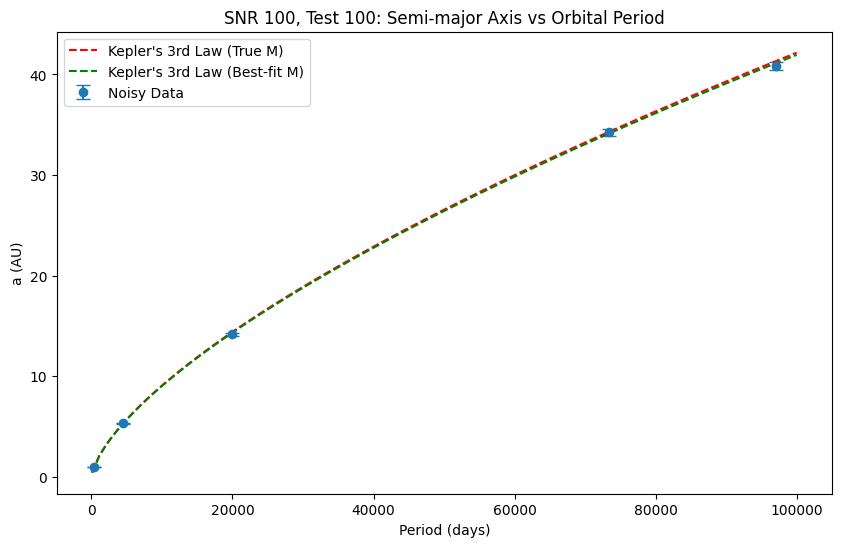

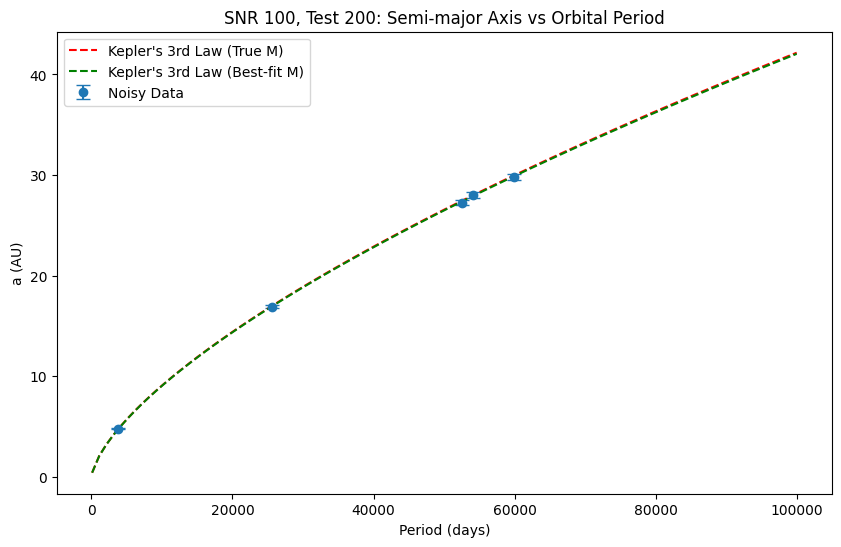

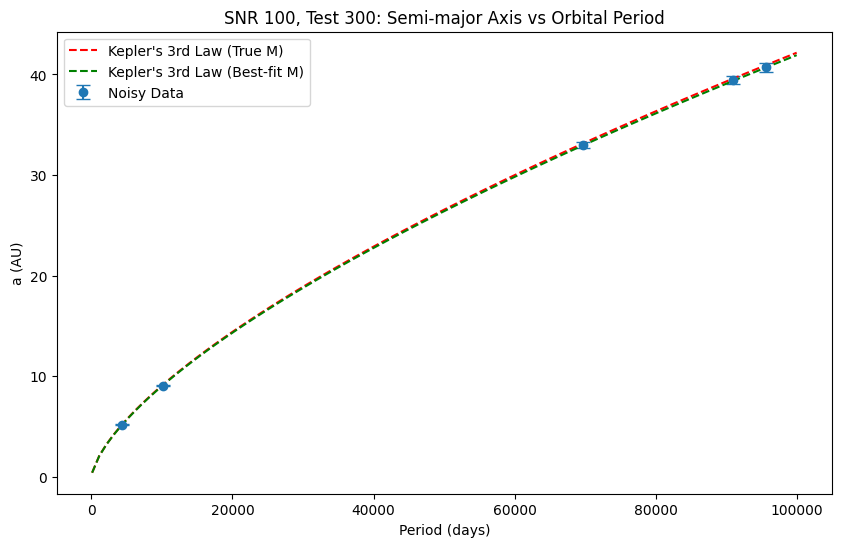

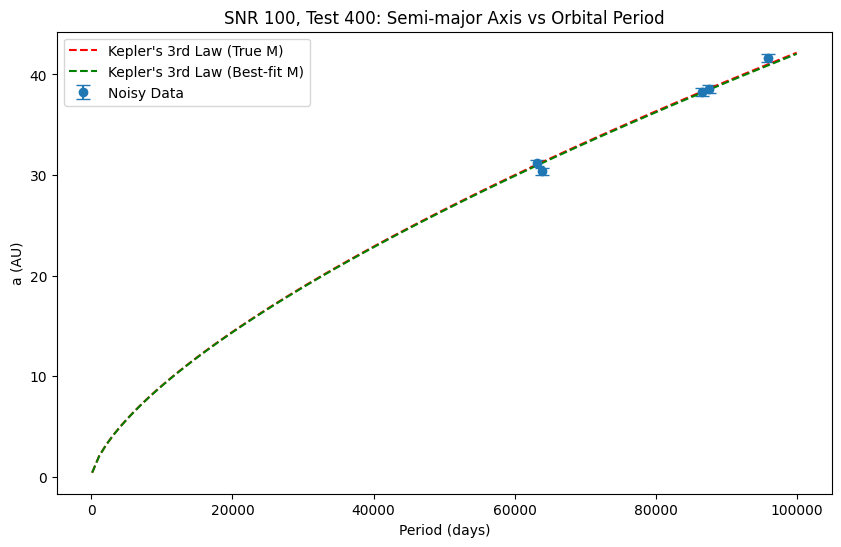

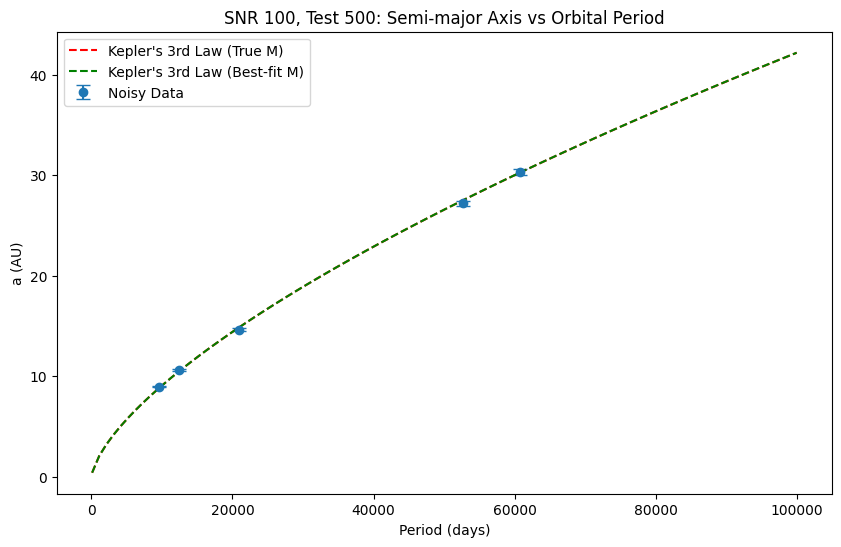

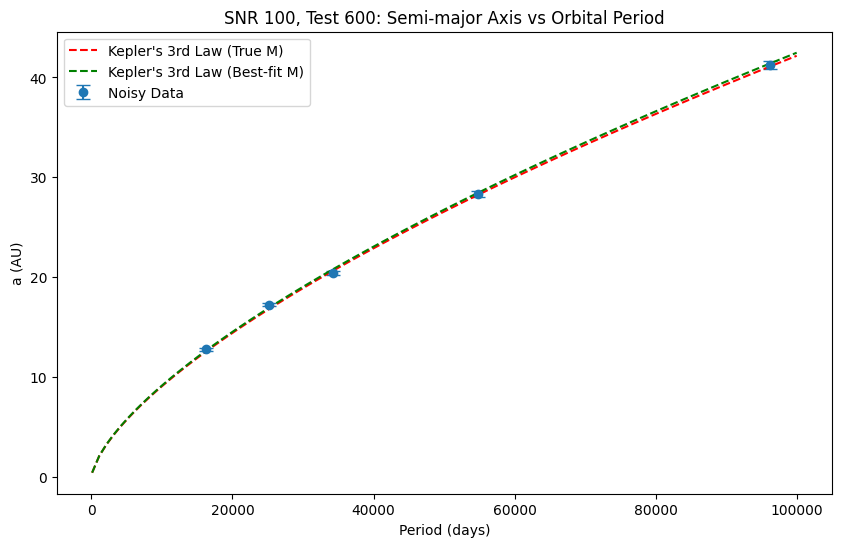

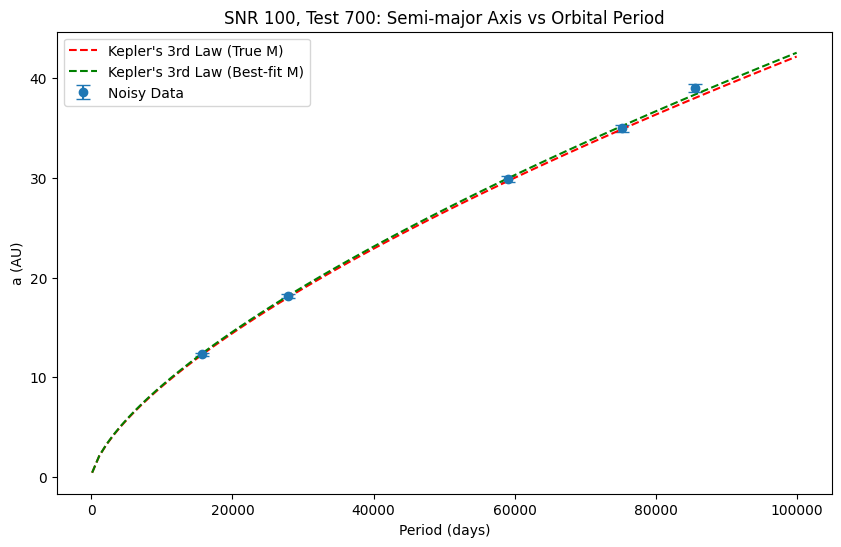

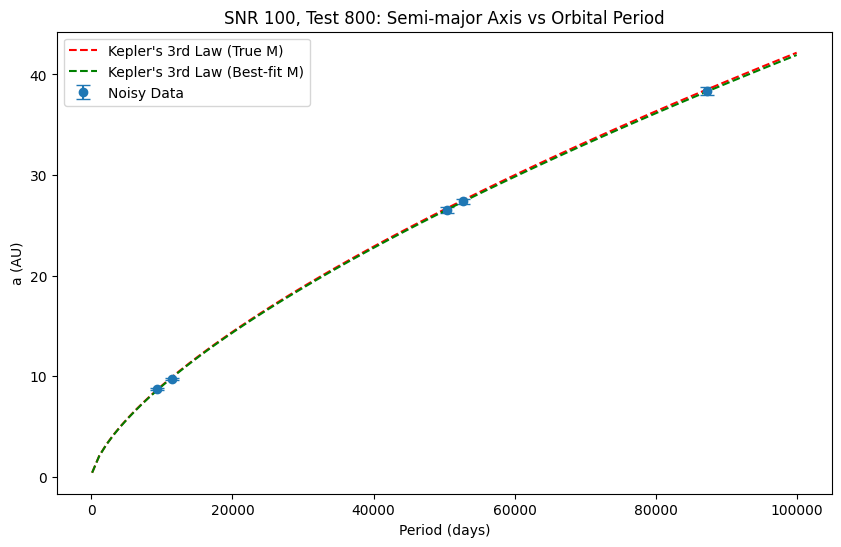

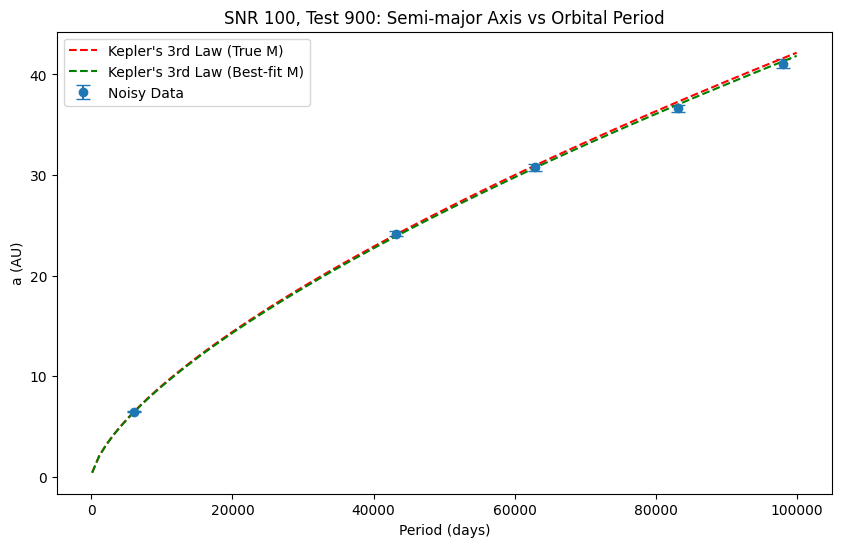

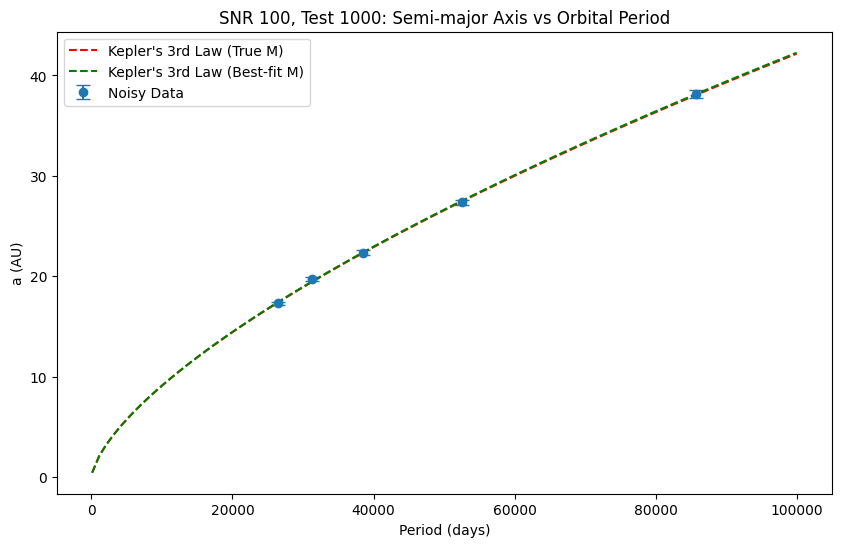

Fraction agreeing within 1sigma: 0.617
Median best-fit mass: 1.988e+30 kg
Uncertainty on median: 1.061e+27 kg
Deviation of median: 0.29sigma
Agrees within uncertainty: True


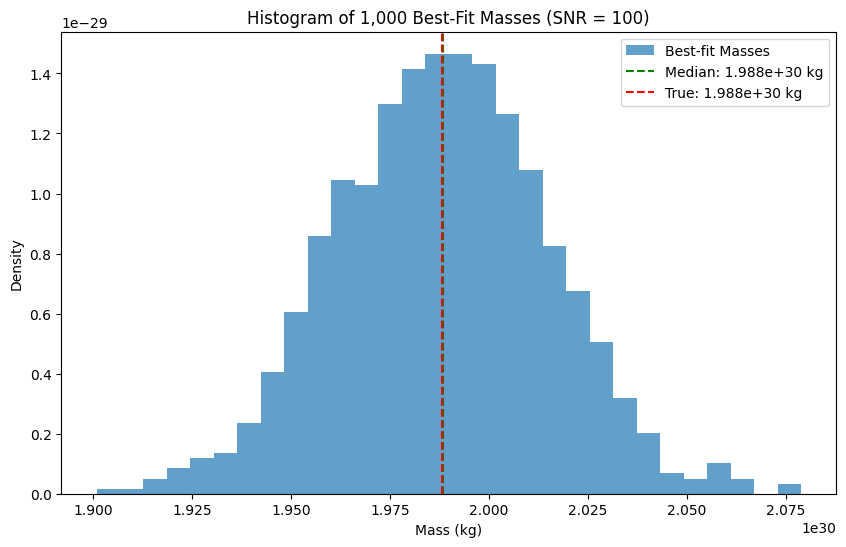

In [170]:
## Step 13: Repeat for different SNRs, which inlcudes all the steps 

snr_values = [1, 3, 5, 100] ## signal-to-noise ratio values
n_tests = 1000 ## number of tests
results = {}

for snr in snr_values:
    print(f"\n SNR = {snr} ")
    best_fit_masses = []
    mass_uncertainties = []
    agrees_within_uncertainty = 0
    
    ## Steps 2-10: 1000 tests
    for i in range(n_tests):
        P_orbitals = np.random.randint(100, 100000, 5)
        a_planets = np.array([sma(p, M_kg) for p in P_orbitals])
        
        ## Step 4: Generating noise with varying SNR
        a_noisy = []
        a_uncertainties = []
        for a_p in a_planets:
            sigma = a_p / snr  
            noise = np.random.normal(loc=0, scale=sigma)
            a_noisy.append(a_p + noise)
            a_uncertainties.append(sigma)
        a_noisy = np.array(a_noisy)
        a_uncertainties = np.array(a_uncertainties)
        
        ## Steps 5-6: Fitting
        popt, pcov = curve_fit(kepler3l, P_orbitals, a_noisy, sigma=a_uncertainties, p0=[M_kg])
        best_fit_mass = popt[0]
        mass_uncertainty = np.sqrt(pcov[0,0])
        
        best_fit_masses.append(best_fit_mass)
        mass_uncertainties.append(mass_uncertainty)
        
        delta_m = abs(best_fit_mass - M_kg)
        if delta_m <= mass_uncertainty:  ## Checking if best-fit mass agrees within uncertainty
            agrees_within_uncertainty += 1
        
        ## Step 5: Plotting every 100th test
        if i % 100 == 99:
            P_range = np.linspace(100, 100000, 100)
            a_theoretical = [kepler3l(p, M_kg) for p in P_range]
            a_best_fit = [kepler3l(p, best_fit_mass) for p in P_range]
            plt.figure(figsize=(10, 6))
            plt.errorbar(P_orbitals, a_noisy, a_uncertainties, fmt='o', capsize=5, label="Noisy Data")
            plt.plot(P_range, a_theoretical, 'r--', label="Kepler's 3rd Law (True M)")
            plt.plot(P_range, a_best_fit, 'g--', label="Kepler's 3rd Law (Best-fit M)")
            plt.xlabel("Period (days)")
            plt.ylabel("a (AU)")
            plt.title(f'SNR {snr}, Test {i+1}: Semi-major Axis vs Orbital Period')
            plt.legend()
            plt.show()
    
    best_fit_masses = np.array(best_fit_masses)
    mass_uncertainties = np.array(mass_uncertainties)
    
    ## Step 9: Fraction
    fraction_agree = agrees_within_uncertainty / n_tests
    print(f"Fraction agreeing within 1sigma: {fraction_agree:.3f}")
    
    ## Step 11: Median and uncertainty
    median_mass = np.median(best_fit_masses)
    std_dev = np.std(best_fit_masses)
    median_uncertainty = 1.253 * std_dev / np.sqrt(n_tests)
    n_sigma_median = abs(median_mass - M_kg) / median_uncertainty
    print(f"Median best-fit mass: {median_mass:.3e} kg")
    print(f"Uncertainty on median: {median_uncertainty:.3e} kg")
    print(f"Deviation of median: {n_sigma_median:.2f}sigma")
    print(f"Agrees within uncertainty: {abs(median_mass - M_kg) <= median_uncertainty}")
    
    ## Step 12: Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(best_fit_masses, bins=30, density=True, alpha=0.7, label="Best-fit Masses")
    plt.axvline(median_mass, color='g', linestyle='--', label=f"Median: {median_mass:.3e} kg")
    plt.axvline(M_kg, color='r', linestyle='--', label=f"True: {M_kg:.3e} kg")
    plt.xlabel("Mass (kg)")
    plt.ylabel("Density")
    plt.title(f"Histogram of 1,000 Best-Fit Masses (SNR = {snr})")
    plt.legend()
    plt.show()

    ## Storing results
    results[snr] = {
        'fraction': fraction_agree,
        'median': median_mass,
        'median_uncertainty': median_uncertainty,
        'best_fit_masses': best_fit_masses
    }
